In [1]:
import numpy as np
import pandas as pd
import ast
import warnings; warnings.simplefilter('ignore')
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [15]:
ratings_small = pd.read_csv("data/ratings_small.csv")
links_small = pd.read_csv("data/links_small.csv")
metadata = pd.read_csv("data/movies_metadata.csv", dtype = {"imdb_id": "string", "original_title": "string",
                                                           "revenue": float, "runtime": float, "title": "string", 
                                                           "vote_average": float, "vote_count": float})
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [8]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
metadata.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


### Data Cleaning and Wrangling

In [16]:
#some rows are missing id values, as well as other info, so I'm removing them
metadata = metadata.drop([19730])
metadata = metadata.drop([29503])
metadata = metadata.drop([35587])
metadata = metadata.reset_index(drop = True)
metadata["id"] = pd.to_numeric(metadata["id"])

In [11]:
#percentage of movies with revenue = 0 aka missing revenue
(metadata['revenue'] == 0).sum()/metadata.shape[0] * 100

83.6988320172448

In [17]:
# several columns are in a json format, so I need to extract the relevant data from them

#production countries
metadata['production_countries'] = metadata['production_countries'].fillna('[]').apply(ast.literal_eval)
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: 
                                                                          [i['name'] for i in x] 
                                                                          if isinstance(x, list) else [])
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: x[0] if len(x)>0 else 0)

#production companies
metadata['production_companies'] = metadata['production_companies'].fillna('[]').apply(ast.literal_eval)
metadata['production_companies'] = metadata['production_companies'].apply(lambda x: 
                                                                          [i['name'] for i in x] 
                                                                          if isinstance(x, list) else [])
metadata['production_companies'] = metadata['production_companies'].apply(lambda x: x[0] if len(x)>0 else 0)

#genres
metadata['genres'] = metadata['genres'].fillna('[]').apply(ast.literal_eval)
metadata['genres'] = metadata['genres'].apply(lambda x: 
                                                                          [i['name'] for i in x] 
                                                                          if isinstance(x, list) else [])

#languages
metadata['spoken_languages'] = metadata['spoken_languages'].fillna('[]').apply(ast.literal_eval)
metadata['spoken_languages'] = metadata['spoken_languages'].apply(lambda x: 
                                                                          [i['name'] for i in x] 
                                                                          if isinstance(x, list) else [])
metadata['spoken_languages'] = metadata['spoken_languages'].apply(lambda x: x[0] if len(x)>0 else 0)

#collection
metadata['belongs_to_collection'] = metadata['belongs_to_collection'].fillna('[]').apply(ast.literal_eval)
metadata['belongs_to_collection'] = metadata['belongs_to_collection'].apply(lambda x: x['name'] if isinstance(x, dict) else 0)

In [18]:
metadata.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,Toy Story Collection,0,Grumpy Old Men Collection,0,Father of the Bride Collection
budget,30000000,65000000,0,16000000,0
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy]
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


In [21]:
#drop columns that have redundent or irrelevent info; create new dataframe called slim
slim = metadata
slim = slim.drop(['adult', 'homepage', 'video', 'imdb_id', 'original_title', 'status', 'poster_path'], axis=1)

In [22]:
#create a new column for the year a film was released
slim['year'] = slim['release_date'].apply(lambda x: str(x).split("-")[0])
slim['year'].head()
slim.head().transpose()

,0,1,2,3,4
belongs_to_collection,Toy Story Collection,0,Grumpy Old Men Collection,0,Father of the Bride Collection
budget,30000000,65000000,0,16000000,0
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy]
id,862,8844,15602,31357,11862
original_language,en,en,en,en,en
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...
popularity,21.946943,17.015539,11.7129,3.859495,8.387519
production_companies,Pixar Animation Studios,TriStar Pictures,Warner Bros.,Twentieth Century Fox Film Corporation,Sandollar Productions
production_countries,United States of America,United States of America,United States of America,United States of America,United States of America
release_date,1995-10-30,1995-12-15,1995-12-22,1995-12-22,1995-02-10


In [23]:
#add a "weighted rating" to each film which takes into account the number of ratings each film received
#make a new data frame that only contains movies with a vote count over a given threshold (90th percentile)
#source: https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

c = slim['vote_average'].mean()
m = slim['vote_count'].quantile(0.9)
q_movies = slim.copy().loc[slim['vote_count'] >= m]

def weighted_rating(x, m=m, c=c):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return round((v/(v+m) * R) + (m/(m+v) * c), 1)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies.head().transpose()

,0,1,4,5,8
belongs_to_collection,Toy Story Collection,0,Father of the Bride Collection,0,0
budget,30000000,65000000,0,60000000,35000000
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]",[Comedy],"[Action, Crime, Drama, Thriller]","[Action, Adventure, Thriller]"
id,862,8844,11862,949,9091
original_language,en,en,en,en,en
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,Just when George Banks has recovered from his ...,"Obsessive master thief, Neil McCauley leads a ...",International action superstar Jean Claude Van...
popularity,21.946943,17.015539,8.387519,17.924927,5.23158
production_companies,Pixar Animation Studios,TriStar Pictures,Sandollar Productions,Regency Enterprises,Universal Pictures
production_countries,United States of America,United States of America,United States of America,United States of America,United States of America
release_date,1995-10-30,1995-12-15,1995-02-10,1995-12-15,1995-12-22


### Exploratory Data Analysis

In [80]:
#idea: which year had the best movies? plot score vs. avg rating for that year of all films, score vs. highest rated film,
#and what that film was, score vs. lowest rated film

#make yearly dataset
years = q_movies.groupby(by="year")['score'].mean().reset_index(name='avg')
len_years = len(years['year'])

#take a look at the average score of films in the last 10 years
years.iloc[len_years-10:]

,year,avg
85,2008,6.165027
86,2009,6.152195
87,2010,6.182673
88,2011,6.137264
89,2012,6.125359
90,2013,6.208560
91,2014,6.220069
92,2015,6.204858
93,2016,6.230000
94,2017,6.222222


In [32]:
#the scores are all very close
#what year had the highest rated films on average?
years.sort_values(by=['avg'], ascending=(False))

,year,avg
14,1936,7.700000
6,1927,7.500000
2,1921,7.300000
26,1949,7.300000
27,1950,7.250000
...,...,...
86,2009,6.152195
80,2003,6.137692
88,2011,6.137264
89,2012,6.125359


In [34]:
#1936
#seems like older films were rated higher on average. Why is this? Less films released, so the ones that came out were 
#higher quality? Perhaps nostalgia? 
#let's take a closer look at 1936 for starters
q_movies.loc[q_movies['year'] == '1936']

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,year,score
3342,0,1,"[Drama, Comedy]",3082,en,The Tramp struggles to live in modern industri...,8.159556,United Artists,United States of America,1936-02-05,8500000.0,87.0,English,He stands alone as the greatest entertainer of...,Modern Times,8.1,881.0,1936,7.7


In [37]:
#only 1 film made it into our "quality movies" dataframe from the year 1936, so that would explain why it has the highest rating
#let's see how many films are in our dataset by year
q_movies.groupby(by="year").size().reset_index(name='count').sort_values(by=['count'], ascending=(False))

,year,count
91,2014,289
90,2013,257
92,2015,247
93,2016,240
88,2011,212
...,...,...
15,1937,1
21,1943,1
23,1945,1
26,1949,1


In [50]:
#from a glance I can see older years have less films, so that might be why they have higher rated films on average
#let's cut down our years dataset to the 90th percentile for the count of films released each year

yc = q_movies.groupby(by="year").size().reset_index(name='count').sort_values(by=['count'], ascending=(False))
quant = yc['count'].quantile(0.75)
yq = yc.copy().loc[yc['count'] >= quant]

#narrow down years dataframe to years that are in yq
years2 = pd.merge(years, yq, how='right', on='year')
years2 = years2.sort_values(by=['avg'], ascending=(False))
years2.head()

,year,avg,count
18,1999,6.389773,88
21,1995,6.364103,78
22,1993,6.329851,67
19,1997,6.311111,81
16,1998,6.285417,96


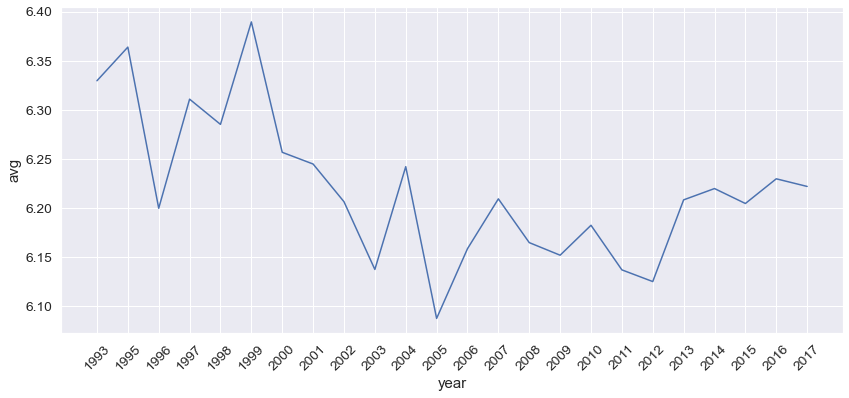

In [58]:
years2 = years2.sort_values(by=['year'], ascending=(True))
plt.figure(figsize=(14,6))
sns.lineplot(data=years2, x = 'year', y = 'avg')
plt.xticks(rotation=45)
plt.show()

In [174]:
#how about finding the highest rated film for a given year
idx = q_movies.groupby(['year'])['score'].transform(max) == q_movies['score']
ym = q_movies[idx][['title', 'year', 'score']].reset_index()
ym.sort_values(by=['year'], ascending=(False)).head(20)

,index,title,year,score
111,42167,Logan,2017,7.6
110,40248,Your Name.,2016,8.1
109,32142,Room,2015,8.0
108,23672,Whiplash,2014,8.2
105,21947,Dallas Buyers Club,2013,7.8
103,21603,Prisoners,2013,7.8
104,21877,12 Years a Slave,2013,7.8
107,22167,Her,2013,7.8
106,22130,The Wolf of Wall Street,2013,7.8
102,20050,Django Unchained,2012,7.8


In [177]:
#or the lowest rated?
idx2 = q_movies.groupby(['year'])['score'].transform(min) == q_movies['score']
ymin = q_movies[idx2][['title', 'year', 'score']].reset_index()
ymin.sort_values(by=['year'], ascending=(False)).head(20)

,index,title,year,score
109,42093,Rings,2017,4.9
108,35326,Fifty Shades of Black,2016,4.7
107,28206,The Boy Next Door,2015,4.3
106,24412,Left Behind,2014,4.3
105,21237,Sharknado,2013,4.3
104,19342,Piranha 3DD,2012,4.6
103,18101,Jack and Jill,2011,4.3
101,15771,Vampires Suck,2010,4.7
100,13566,Dragonball Evolution,2009,3.6
99,12911,Disaster Movie,2008,4.1


In [ ]:
#TODO: pivot tables, solve issue above (get the top rated film from each year) (SOLVED)